In [1]:
print("Hello")

Hello


In [1]:
!pip install gdown # https://drive.google.com/file/d/1ZnddoU-eLDWYWu-FlJ6AG3Y50cFk7Kex/view?usp=sharing
!gdown 1ZnddoU-eLDWYWu-FlJ6AG3Y50cFk7Kex

Downloading...
From (original): https://drive.google.com/uc?id=1ZnddoU-eLDWYWu-FlJ6AG3Y50cFk7Kex
From (redirected): https://drive.google.com/uc?id=1ZnddoU-eLDWYWu-FlJ6AG3Y50cFk7Kex&confirm=t&uuid=e9f5dc6f-14fb-4868-af03-02663d996a0d
To: /kaggle/working/currency-sample-30.zip
100%|██████████████████████████████████████| 42.4M/42.4M [00:00<00:00, 53.2MB/s]


In [2]:
# =============================================================
#   1. INSTALL DEPENDENCIES
# =============================================================
!pip install torch torchvision albumentations==1.3.0 opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [3]:
# =============================================================
#   2. IMPORT LIBRARIES
# =============================================================

import os
import cv2
import glob
import torch
import random
import shutil
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
import zipfile
import os

zip_path = "/kaggle/working/currency-sample-30.zip"  # Replace with your actual ZIP file name
extract_path = "/kaggle/working"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Delete the ZIP file after extraction
os.remove(zip_path)

print("Extraction completed and ZIP file deleted!")

Extraction completed and ZIP file deleted!


In [5]:
# =============================================================
#   3. SET YOUR DATASET PATH (EDIT ONLY THIS!)
# =============================================================

# This should contain:
# images/        -> all currency images (.jpg)
# labels/        -> YOLO label files (.txt)
DATASET_PATH = "/kaggle/working/currency-sample-30"

IMG_DIR = DATASET_PATH + "/images"
LBL_DIR = DATASET_PATH + "/labels"

print("Images:", len(glob.glob(IMG_DIR + "/*.jpg")))
print("Labels:", len(glob.glob(LBL_DIR + "/*.txt")))

Images: 184
Labels: 185


In [6]:
# =============================================================
#   4. YOLO IMAGE DATASET FOR TRAINING GAN
# =============================================================

class CurrencyDataset(Dataset):
    def __init__(self, img_dir, img_size=128):
        self.img_paths = sorted(glob.glob(img_dir + "/*.jpg"))
        self.img_size = img_size

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = img.astype(np.float32) / 255.0
        img = torch.tensor(img).permute(2, 0, 1)
        return img

In [18]:
# =============================================================
#   5. DEFINE DCGAN ARCHITECTURE
# =============================================================

nz = 100   # noise vector
ngf = 64   # gen filters
ndf = 64   # disc filters
nc = 3     # RGB channels

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 3, 1, 1),
        )

        # ❤️ THIS FIXES EVERYTHING  
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.main(x)            # [batch, 1, H, W]
        x = self.pool(x)            # → [batch, 1, 1, 1]
        x = self.sigmoid(x)
        return x.view(-1, 1)


  


In [19]:
#print(netD(real_imgs).shape)

torch.Size([800, 1])


In [20]:
# =============================================================
#   6. TRAIN THE GAN
# =============================================================

dataset = CurrencyDataset(IMG_DIR, img_size=128)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

netG = Generator().to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002)
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002)

epochs = 80  # you can increase to 150

for epoch in range(epochs):
    for i, real_imgs in enumerate(loader):
        real_imgs = real_imgs.to(device)
        b = real_imgs.size(0)

        # ---- Train Discriminator ----
        noise = torch.randn(b, nz, 1, 1).to(device)
        fake_imgs = netG(noise)

        optimizerD.zero_grad()

        real_label = torch.ones(b, 1).to(device)
        fake_label = torch.zeros(b, 1).to(device)

        d_real = criterion(netD(real_imgs), real_label)
        d_fake = criterion(netD(fake_imgs.detach()), fake_label)

        lossD = d_real + d_fake
        lossD.backward()
        optimizerD.step()

        # ---- Train Generator ----
        optimizerG.zero_grad()

        g_loss = criterion(netD(fake_imgs), real_label)
        g_loss.backward()
        optimizerG.step()

    print(f"Epoch {epoch+1}/{epochs}: LossD={lossD.item():.4f}  LossG={g_loss.item():.4f}")

Epoch 1/80: LossD=0.3633  LossG=2.0494
Epoch 2/80: LossD=0.1287  LossG=2.7366
Epoch 3/80: LossD=0.0760  LossG=3.2578
Epoch 4/80: LossD=0.0524  LossG=3.8119
Epoch 5/80: LossD=0.0341  LossG=4.1887
Epoch 6/80: LossD=0.0240  LossG=4.5777
Epoch 7/80: LossD=0.0206  LossG=4.8077
Epoch 8/80: LossD=0.0182  LossG=5.0192
Epoch 9/80: LossD=0.0144  LossG=5.2542
Epoch 10/80: LossD=0.0137  LossG=5.2660
Epoch 11/80: LossD=0.0140  LossG=5.3058
Epoch 12/80: LossD=0.0132  LossG=5.5109
Epoch 13/80: LossD=0.0088  LossG=5.7882
Epoch 14/80: LossD=0.0093  LossG=5.7338
Epoch 15/80: LossD=0.0103  LossG=5.6326
Epoch 16/80: LossD=0.0113  LossG=5.7712
Epoch 17/80: LossD=0.0085  LossG=6.0769
Epoch 18/80: LossD=0.0071  LossG=6.0520
Epoch 19/80: LossD=0.0091  LossG=6.0285
Epoch 20/80: LossD=0.0057  LossG=6.2768
Epoch 21/80: LossD=0.0106  LossG=5.9421
Epoch 22/80: LossD=0.0054  LossG=6.4193
Epoch 23/80: LossD=0.0042  LossG=6.5736
Epoch 24/80: LossD=0.0071  LossG=6.2699
Epoch 25/80: LossD=0.0042  LossG=6.6348
Epoch 26/

In [21]:
# =============================================================
#   7. GENERATE 5000 GAN IMAGES
# =============================================================
GAN_OUT = "/kaggle/working/gan_images"
os.makedirs(GAN_OUT, exist_ok=True)

print("Generating 5000 synthetic images...")

for i in range(5000):
    noise = torch.randn(1, nz, 1, 1).to(device)
    fake = netG(noise)[0]

    img = fake.detach().cpu().permute(1, 2, 0).numpy()
    img = ((img + 1) * 127.5).astype(np.uint8)

    cv2.imwrite(f"{GAN_OUT}/{i}.jpg", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

print("Done generating GAN images!")

Generating 5000 synthetic images...
Done generating GAN images!


In [22]:
# =============================================================
#   8. YOLO LABEL AUGMENTATION USING ORIGINAL LABEL FILES
# =============================================================

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=12, p=0.4),
    A.GaussianBlur(p=0.3),
], bbox_params=A.BboxParams(format='yolo', label_fields=['cls']))

orig_imgs = sorted(glob.glob(IMG_DIR + "/*.jpg"))
orig_lbls = sorted(glob.glob(LBL_DIR + "/*.txt"))

OUT_IMG = "/kaggle/working/final_dataset/images"
OUT_LBL = "/kaggle/working/final_dataset/labels"

os.makedirs(OUT_IMG, exist_ok=True)
os.makedirs(OUT_LBL, exist_ok=True)

print("Creating final YOLO-annotated dataset of 5000 samples...")

for i in range(5000):
    idx = random.randint(0, len(orig_imgs)-1)

    img = cv2.imread(orig_imgs[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Load labels
    boxes, cls = [], []
    with open(orig_lbls[idx], "r") as f:
        for line in f:
            c, x, y, w, h = map(float, line.split())
            boxes.append([x, y, w, h])
            cls.append(int(c))

    transformed = transform(image=img, bboxes=boxes, cls=cls)
    aug_img = transformed["image"]
    aug_boxes = transformed["bboxes"]
    aug_cls = transformed["cls"]

    cv2.imwrite(f"{OUT_IMG}/{i}.jpg", cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

    with open(f"{OUT_LBL}/{i}.txt", "w") as f:
        for c, (x, y, w, h) in zip(aug_cls, aug_boxes):
            f.write(f"{c} {x} {y} {w} {h}\n")

print("Dataset ready!")

Creating final YOLO-annotated dataset of 5000 samples...
Dataset ready!


In [1]:
!pip uninstall -y tensorflow

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1


In [2]:
!pip install tensorflow==2.17.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 3.0 MB/s eta 0:00:000:00:0100:01


In [3]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [4]:
!pip install ultralytics==8.3.45 --no-deps
!pip install opencv-python-headless==4.10.0.84 --no-deps
!pip install pillow==11.0.0 --no-deps
!pip install thop --no-deps

ERROR: Ignored the following yanked versions: 8.0.12, 8.0.15, 8.0.129, 8.0.174, 8.0.177, 8.1.21, 8.1.31, 8.2.7, 8.2.47
ERROR: Could not find a version that satisfies the requirement ultralytics==8.3.45 (from versions: 0.0.13, 0.0.14, 0.0.15, 0.0.16, 0.0.17, 0.0.18, 0.0.19, 0.0.20, 0.0.21, 0.0.22, 0.0.23, 0.0.24, 0.0.25, 0.0.26, 0.0.27, 0.0.28, 0.0.29, 0.0.30, 0.0.31, 0.0.32, 0.0.33, 0.0.34, 0.0.35, 0.0.36, 0.0.37, 0.0.38, 0.0.39, 0.0.40, 0.0.41, 0.0.42, 0.0.43, 0.0.44, 8.0.0, 8.0.1, 8.0.2, 8.0.3, 8.0.4, 8.0.5, 8.0.6, 8.0.7, 8.0.8, 8.0.9, 8.0.10, 8.0.11, 8.0.13, 8.0.14, 8.0.16, 8.0.17, 8.0.18, 8.0.19, 8.0.20, 8.0.21, 8.0.22, 8.0.23, 8.0.24, 8.0.25, 8.0.26, 8.0.27, 8.0.28, 8.0.29, 8.0.30, 8.0.31, 8.0.32, 8.0.33, 8.0.34, 8.0.35, 8.0.36, 8.0.37, 8.0.38, 8.0.39, 8.0.40, 8.0.41, 8.0.42, 8.0.43, 8.0.44, 8.0.45, 8.0.46, 8.0.47, 8.0.48, 8.0.49, 8.0.50, 8.0.51, 8.0.52, 8.0.53, 8.0.54, 8.0.55, 8.0.56, 8.0.57, 8.0.58, 8.0.59, 8.0.60, 8.0.61, 8.0.62, 8.0.63, 8.0.64, 8.0.65, 8.0.66, 8.0.67, 8.0.68, 

In [5]:
!pip install roboflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 97.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 82.2 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 0.2.2 requires pillow<12.0.0,>=10.0.0, but you have pillow 12.0.0 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.4 requires matplotlib>=3.8.0, but you have matplotlib 3.7.5 which is incompatible.


In [6]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.6 MB/s eta 0:00:00a 0:00:01


In [7]:
import roboflow
print(f"Roboflow version: {roboflow.__version__}")

Roboflow version: 1.2.11


In [7]:
from ultralytics import YOLO

# Check if the library is installed
print("Ultralytics installed successfully!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics installed successfully!


In [8]:
!pip install gdown # https://drive.google.com/file/d/1RI-8RHbm-gzO2mMcnJ_IkhGV8fzkbBQO/view?usp=sharing
!gdown 1RI-8RHbm-gzO2mMcnJ_IkhGV8fzkbBQO

Downloading...
From (original): https://drive.google.com/uc?id=1RI-8RHbm-gzO2mMcnJ_IkhGV8fzkbBQO
From (redirected): https://drive.google.com/uc?id=1RI-8RHbm-gzO2mMcnJ_IkhGV8fzkbBQO&confirm=t&uuid=3f32ee7a-71f1-4566-965b-f64336966ccf
To: /kaggle/working/patch_dataset.zip
100%|██████████████████████████████████████| 1.29G/1.29G [00:18<00:00, 68.4MB/s]


In [9]:
import zipfile
import os

zip_path = "/kaggle/working/patch_dataset.zip"  # Replace with your actual ZIP file name
extract_path = "/kaggle/working"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Delete the ZIP file after extraction
os.remove(zip_path)

print("Extraction completed and ZIP file deleted!")

Extraction completed and ZIP file deleted!


In [11]:
from roboflow import Roboflow
rf = Roboflow(api_key="q3mA5r8nbvMj7Ox5b4Bn")
project = rf.workspace("anmol-2fimi").project("license-plate-detection-po2qy")
version = project.version(2)
dataset = version.download("yolov11")                      

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to License-Plate-Detection-2 in yolov11:: 100%|██████████| 4932/4932 [00:00<00:00, 8661.90it/s]


In [12]:
from roboflow import Roboflow
rf = Roboflow(api_key="q3mA5r8nbvMj7Ox5b4Bn")
project = rf.workspace("juli-herniyansah-nbg5q").project("anpr_project_merge")
version = project.version(1)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ANPR_PROJECT_MERGE-1 in yolov11:: 100%|██████████| 16552/16552 [00:01<00:00, 10135.15it/s]


In [13]:
from roboflow import Roboflow
rf = Roboflow(api_key="q3mA5r8nbvMj7Ox5b4Bn")
project = rf.workspace("richard-audette").project("platemodel")
version = project.version(4)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to platemodel-4 in yolov11:: 100%|██████████| 42642/42642 [00:04<00:00, 9710.30it/s] 


In [14]:
from roboflow import Roboflow
rf = Roboflow(api_key="q3mA5r8nbvMj7Ox5b4Bn")
project = rf.workspace("augmented-startups").project("vehicle-registration-plates-trudk")
version = project.version(2)
dataset = version.download("yolov11")                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Vehicle-Registration-Plates-2 in yolov11:: 100%|██████████| 42362/42362 [00:04<00:00, 9044.40it/s] 


In [15]:
import os
import shutil

# Source folders
source_folders = [
    "/kaggle/working/ANPR_PROJECT_MERGE-1",
    "/kaggle/working/License-Plate-Detection-2",
    "/kaggle/working/Vehicle-Registration-Plates-2",
    "/kaggle/working/platemodel-4"
]

# Destination folder
destination_folder = "/kaggle/working/decision"
subdirs = ["train", "test", "valid"]
content_dirs = ["images", "labels"]

# Create directories if they don't exist
for subdir in subdirs:
    for content_dir in content_dirs:
        os.makedirs(os.path.join(destination_folder, subdir, content_dir), exist_ok=True)

# Function to copy files from source to destination
def copy_files(src, dest):
    for root, _, files in os.walk(src):
        for file in files:
            src_file_path = os.path.join(root, file)
            relative_path = os.path.relpath(root, src)
            dest_dir_path = os.path.join(dest, relative_path)
            os.makedirs(dest_dir_path, exist_ok=True)
            shutil.copy2(src_file_path, dest_dir_path)

# Copy files from each source folder
for folder in source_folders:
    for subdir in subdirs:
        for content_dir in content_dirs:
            source_path = os.path.join(folder, subdir, content_dir)
            destination_path = os.path.join(destination_folder, subdir, content_dir)
            copy_files(source_path, destination_path)

print("Files copied successfully.")

Files copied successfully.


In [16]:
import shutil

# Source and destination paths
source_path = '/kaggle/working/Vehicle-Registration-Plates-2/data.yaml'
destination_path = '/kaggle/working'

# Copy the folder
shutil.copy(source_path, destination_path)

print(f"Folder copied successfully from {source_path} to {destination_path}")

Folder copied successfully from /kaggle/working/Vehicle-Registration-Plates-2/data.yaml to /kaggle/working


In [11]:
import yaml

def update_yaml_content(file_path, new_content):
    try:
        # Write the new content to the YAML file
        with open(file_path, 'w') as file:
            yaml.dump(new_content, file)

        print("File updated successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Define the yaml file path
file_path = '/kaggle/working/data.yaml'

# Define the new content
new_content = {
    'names': ['watermark_window','security_thread','number_panel'], 
    'nc': 3,  
    'test': '/kaggle/working/patch_dataset/test/images', 
    'train': '/kaggle/working/patch_dataset/train/images', 
    'val': '/kaggle/working/patch_dataset/valid/images'
}

# Call the function to update the YAML file
update_yaml_content(file_path, new_content)

File updated successfully.


In [12]:
import yaml

def view_yaml_file(file_path):
    with open(file_path, 'r') as file:
        yaml_content = yaml.safe_load(file)
        return yaml_content

file_path = "/kaggle/working/data.yaml"
yaml_content = view_yaml_file(file_path)
print(yaml_content)

{'names': ['watermark_window', 'security_thread', 'number_panel'], 'nc': 3, 'test': '/kaggle/working/patch_dataset/test/images', 'train': '/kaggle/working/patch_dataset/train/images', 'val': '/kaggle/working/patch_dataset/valid/images'}


In [15]:
from ultralytics import YOLO

# Build a YOLOv9c model from scratch
model = YOLO('yolov10n.yaml')

# Build a YOLOv9c model from pretrained weight
model = YOLO('yolov10n.pt')

# Display model information (optional)
model.info()

YOLOv10n summary: 223 layers, 2,775,520 parameters, 0 gradients, 8.7 GFLOPs


(223, 2775520, 0, 8.7404288)

In [16]:
results = model.train(data='/kaggle/working/data.yaml', epochs=50,
                    batch=32,cache=True,save_period=30,imgsz=300)

Ultralytics 8.3.235 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=300, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        500       1425      0.971      0.973      0.992      0.899
      watermark_window        497        497      0.994          1      0.995      0.952
       security_thread        425        428      0.942      0.953      0.988      0.854
          number_panel        497        500      0.978      0.966      0.993      0.892
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to /kaggle/working/runs/detect/train2


In [ ]:
from IPython.display import Image, display

# Display results.png
display(Image(filename='/kaggle/working/runs/detect/train/results.png'))


In [ ]:
from IPython.display import Image, display

# Display results.png
display(Image(filename='/kaggle/working/runs/detect/train/F1_curve.png'))

In [ ]:
from IPython.display import Image, display

# Display results.png
display(Image(filename='/kaggle/working/runs/detect/train/PR_curve.png'))

In [ ]:
from IPython.display import Image, display

# Display results.png
display(Image(filename='/kaggle/working/runs/detect/train/P_curve.png'))

In [ ]:
from IPython.display import Image, display

# Display results.png
display(Image(filename='/kaggle/working/runs/detect/train/R_curve.png'))

In [ ]:
from IPython.display import Image, display

# Display results.png
display(Image(filename='/kaggle/working/runs/detect/train/confusion_matrix.png'))

In [18]:
import shutil

# Compress the folder
shutil.make_archive('yolo_dataset', 'zip', '/kaggle/working/patch_dataset')

# Download the zip file from the "Files" tab

'/kaggle/working/yolo_dataset.zip'


image 1/1 /kaggle/working/patch_dataset/test/images/56.jpg: 320x320 1 watermark_window, 1 security_thread, 1 number_panel, 9.1ms
Speed: 1.2ms preprocess, 9.1ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 320)
Results saved to /kaggle/working/runs/detect/predict


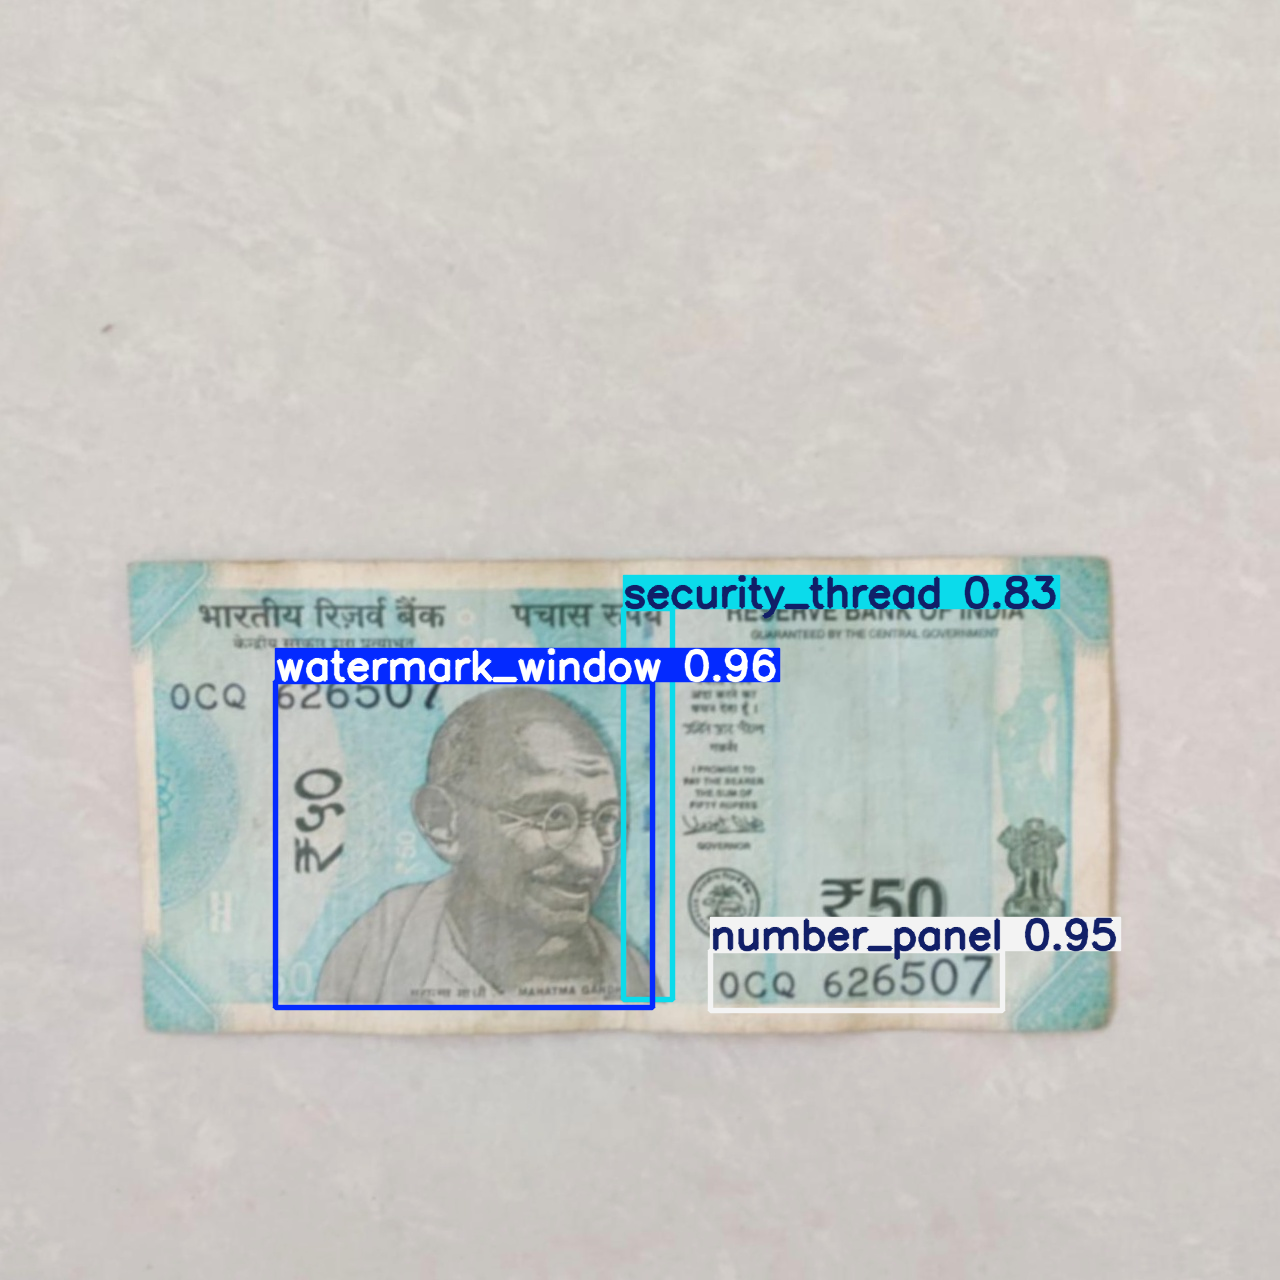

In [17]:
from ultralytics import YOLO

# Load a model
model = YOLO("/kaggle/working/runs/detect/train2/weights/best.pt")

# Perform object detection on an image
results = model("/kaggle/working/patch_dataset/test/images/56.jpg", save=True)
results[0].show()